<a href="https://colab.research.google.com/github/mot1122/CNN_model/blob/main/fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning
## Baseline

In [2]:
import os,random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras import models,layers
import cv2
from PIL import Image

In [3]:
train,test=tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 13s 0us/step


In [4]:
train[0].shape, train[1].shape

((50000, 32, 32, 3), (50000, 1))

In [5]:
test[0].shape, test[1].shape

((10000, 32, 32, 3), (10000, 1))

In [6]:
X_train,y_train=train
X_test,y_test=test

In [7]:
X_train,X_test=X_train/255,X_test/255

In [8]:
X_train,y_train=X_train.astype("float16"),y_train.astype("float16")
X_test,y_test=X_test.astype("int8"),y_test.astype("int8"),

In [9]:
def reset_seed(seed=0):
  os.environ["PYTHONHASHSEED"]="0"
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

In [10]:
reset_seed(0)
model=models.Sequential([
  layers.Conv2D(filters=3,kernel_size=(3,3),activation="relu",input_shape=(32, 32, 3)),
  layers.MaxPool2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(100,activation="relu"),
  layers.Dense(10,activation="softmax")                       
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 3)         84        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 3)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 675)               0         
                                                                 
 dense (Dense)               (None, 100)               67600     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 68,694
Trainable params: 68,694
Non-trainable params: 0
____________________________________________________

In [12]:
optimizer=tf.keras.optimizers.Adam(lr=0.01)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [14]:
batch_size=4096
epochs=10
history=model.fit(X_train,y_train,
                  batch_size=batch_size,epochs=epochs,
                  validation_data=(X_test,y_test))

Epoch 1/10
13/13 [==============================] - 5s 75ms/step - loss: 2.1486 - accuracy: 0.2157 - val_loss: 2.6526 - val_accuracy: 0.1199
Epoch 2/10
13/13 [==============================] - 0s 36ms/step - loss: 1.8429 - accuracy: 0.3538 - val_loss: 3.2310 - val_accuracy: 0.1163
Epoch 3/10
13/13 [==============================] - 1s 39ms/step - loss: 1.6617 - accuracy: 0.4100 - val_loss: 3.6797 - val_accuracy: 0.1114
Epoch 4/10
13/13 [==============================] - 0s 36ms/step - loss: 1.5690 - accuracy: 0.4396 - val_loss: 3.9085 - val_accuracy: 0.1136
Epoch 5/10
13/13 [==============================] - 0s 37ms/step - loss: 1.4936 - accuracy: 0.4677 - val_loss: 3.9951 - val_accuracy: 0.1112
Epoch 6/10
13/13 [==============================] - 0s 36ms/step - loss: 1.4394 - accuracy: 0.4876 - val_loss: 4.1002 - val_accuracy: 0.1149
Epoch 7/10
13/13 [==============================] - 0s 36ms/step - loss: 1.4140 - accuracy: 0.4949 - val_loss: 4.1034 - val_accuracy: 0.1143
Epoch 8/10
13

In [15]:
!nvidia-smi

Sun Mar 13 11:40:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    32W /  70W |   1816MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## FIne tuned VGG16

In [16]:
from tensorflow.keras.applications import resnet,VGG16

In [17]:
base_model=VGG16(input_shape=(224,224,3),include_top=False,weights="imagenet")

58900480/58889256 [==============================] - 2s 0us/step


In [18]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
# RAMクラッシュ防止のため少なめに設定
train_choice=np.random.randint(low=0,high=50000,size=3000)
test_choice=np.random.randint(low=0,high=10000,size=500)

In [20]:
X_train,y_train=train
X_test,y_test=test

In [21]:
X_train,y_train=X_train[train_choice],y_train[train_choice].astype("int8")
X_test,y_test=X_test[test_choice],y_test[test_choice].astype("int8")

In [22]:
_train,_test=[],[]
for img in X_train:
  _train.append(cv2.resize(src=img,dsize=(224,224)))
for img in X_test:
  _test.append(cv2.resize(src=img,dsize=(224,224)))

In [23]:
X_train=np.array(_train,dtype="float16")/255
X_test=np.array(_test,dtype="float16")/255

In [24]:
X_train.shape,X_test.shape

((3000, 224, 224, 3), (500, 224, 224, 3))

In [25]:
reset_seed(0)
finetuned_model=models.Sequential([
  base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(512,activation="relu"),
  layers.Dense(10,activation="softmax")
])

In [26]:
optimizer=tf.keras.optimizers.SGD(lr=0.01)
finetuned_model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
    )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [27]:
finetuned_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14,982,474
Trainable params: 14,982,474
Non-trainable params: 0
_________________________________________________________________


In [28]:
loss,accuracy=finetuned_model.evaluate(X_test,y_test)

16/16 [==============================] - 7s 259ms/step - loss: 2.4414 - accuracy: 0.0980


In [29]:
print(f"loss:{loss:.2f},accuracy:{accuracy:.2f}")

loss:2.44,accuracy:0.10


In [30]:
history=finetuned_model.fit(X_train,y_train,
                            epochs=10,
                            batch_size=32,
                            validation_data=(X_test,y_test))

Epoch 1/10
94/94 [==============================] - 50s 480ms/step - loss: 2.2545 - accuracy: 0.1497 - val_loss: 2.1561 - val_accuracy: 0.2080
Epoch 2/10
94/94 [==============================] - 40s 431ms/step - loss: 2.1280 - accuracy: 0.2287 - val_loss: 2.2725 - val_accuracy: 0.2160
Epoch 3/10
94/94 [==============================] - 41s 436ms/step - loss: 2.0291 - accuracy: 0.2577 - val_loss: 1.6770 - val_accuracy: 0.4240
Epoch 4/10
94/94 [==============================] - 41s 441ms/step - loss: 1.8160 - accuracy: 0.3473 - val_loss: 1.5032 - val_accuracy: 0.5320
Epoch 5/10
94/94 [==============================] - 42s 444ms/step - loss: 1.5322 - accuracy: 0.4627 - val_loss: 1.3343 - val_accuracy: 0.5740
Epoch 6/10
94/94 [==============================] - 42s 446ms/step - loss: 1.6476 - accuracy: 0.4080 - val_loss: 2.2679 - val_accuracy: 0.1560
Epoch 7/10
94/94 [==============================] - 42s 452ms/step - loss: 1.5732 - accuracy: 0.4257 - val_loss: 0.9790 - val_accuracy: 0.6600

In [31]:
results=pd.DataFrame(history.history)
results.tail(5)

,loss,accuracy,val_loss,val_accuracy
5,1.647586,0.408000,2.267871,0.156
6,1.573223,0.425667,0.978958,0.660
7,1.164893,0.597667,1.526910,0.482
8,0.968224,0.662667,1.273956,0.594
9,0.949160,0.678000,1.367350,0.504


Text(0.5, 0, 'epochs')

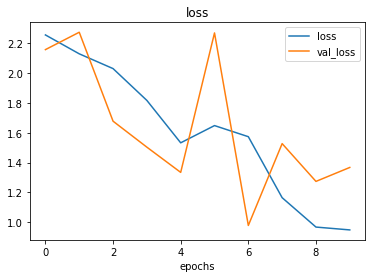

In [32]:
results[["loss","val_loss"]].plot(title="loss")
plt.xlabel("epochs")

Text(0.5, 0, 'epochs')

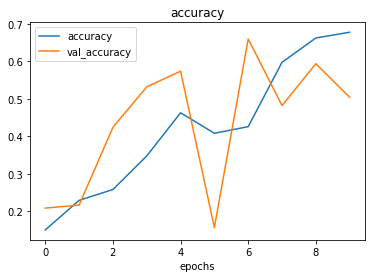

In [33]:
results[["accuracy","val_accuracy"]].plot(title="accuracy")
plt.xlabel("epochs")